## Experiment Notebook

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
# import torchvision
# import torchvision.transforms as transforms
# from torchvision import models
from torch.utils.data import DataLoader, random_split
import torch.nn.init as init
import numpy as np
import random
import matplotlib.pyplot as plt

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Train student from scratch without Teacher



### Load data

In [ ]:
transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [ ]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize((224, 224)),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_dataset_val = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:13<00:00, 12583486.20it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Hyperparameters
batch_size = 128
learning_rate = 0.1


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
train_loader_val = DataLoader(train_dataset_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Load ResNet18 Student model

In [ ]:
student = models.resnet18()

In [ ]:
student.fc = nn.Linear(student.fc.in_features, 10)
student = student.to(device)

In [ ]:
for param in student.parameters():
    param.requires_grad = True

### Train Student without teacher

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(student.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

In [ ]:
num_epochs = 50
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(num_epochs):
    student.train()

    # Train
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate
    # on training data without augment
    student.eval()
    current_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for data in train_loader_val:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(current_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)
    print('[%d] train_loss: %.3f, train_accuracy: %.2f %%' %
     (epoch + 1, current_loss / len(train_loader), 100 * correct / total))

    # on testing data
    correct_test = 0
    total_test = 0
    test_current_loss = 0.0
    with torch.no_grad():
      for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        test_current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_loss.append(test_current_loss / len(test_loader))
    test_accuracy.append(100 * correct_test / total_test)
    print('[%d] test_loss: %.3f, test_accuracy: %.2f %%' %
     (epoch + 1, test_current_loss / len(test_loader), 100 * correct_test / total_test))

    scheduler.step()



[1] train_loss: 1.625, train_accuracy: 42.69 %
[1] test_loss: 1.621, test_accuracy: 42.41 %
[2] train_loss: 1.335, train_accuracy: 51.32 %
[2] test_loss: 1.338, test_accuracy: 50.79 %
[3] train_loss: 1.309, train_accuracy: 53.16 %
[3] test_loss: 1.336, test_accuracy: 51.80 %
[4] train_loss: 1.041, train_accuracy: 62.62 %
[4] test_loss: 1.056, test_accuracy: 62.38 %
[5] train_loss: 0.928, train_accuracy: 67.26 %
[5] test_loss: 0.973, test_accuracy: 65.51 %
[6] train_loss: 1.007, train_accuracy: 65.19 %
[6] test_loss: 1.062, test_accuracy: 63.49 %
[7] train_loss: 0.918, train_accuracy: 68.18 %
[7] test_loss: 0.982, test_accuracy: 66.44 %
[8] train_loss: 0.728, train_accuracy: 74.54 %
[8] test_loss: 0.797, test_accuracy: 72.25 %
[9] train_loss: 0.686, train_accuracy: 76.55 %
[9] test_loss: 0.772, test_accuracy: 73.95 %
[10] train_loss: 0.719, train_accuracy: 75.12 %
[10] test_loss: 0.790, test_accuracy: 72.70 %
[11] train_loss: 0.643, train_accuracy: 77.60 %
[11] test_loss: 0.728, test_ac

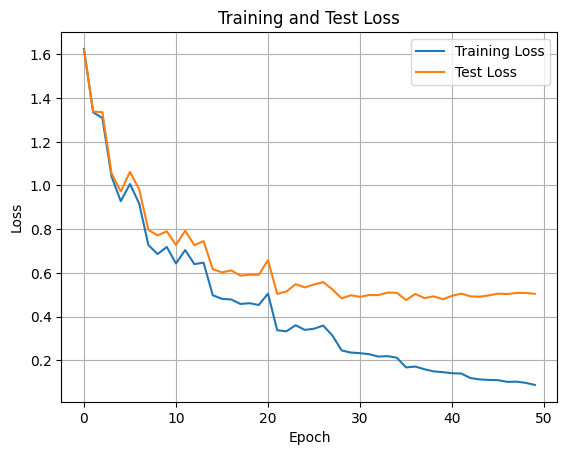

In [ ]:
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid()
plt.show()

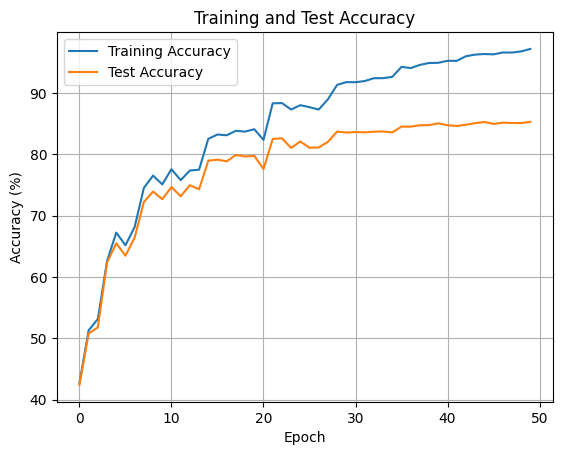

In [ ]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.legend()
plt.grid()
plt.show()

In [ ]:
torch.save(student.state_dict(), "/content/drive/MyDrive/Colab Notebooks/resnet18_student_non_learning.pth")

Mounted at /content/drive


## Train student with Teacher

In [ ]:
# Hyperparameters
learning_rate = 0.1
batch_size = 128
T = 3
soft_target_loss_weight = 0.6

In [3]:
transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# transform_train_student = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ])

transform_teacher = transforms.Compose([
        transforms.Resize(224),
    ])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_dataset_val = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_val = DataLoader(train_dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
student = models.resnet18()
student.fc = nn.Linear(student.fc.in_features, 10)
student = student.to(device)
for param in student.parameters():
    param.requires_grad = True

In [ ]:
teacher = models.resnet50()
teacher.fc = nn.Linear(teacher.fc.in_features, 10)
teacher.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/teacher_finetuned_cifar10_v2.pth'))
teacher = teacher.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
criterion_kd = nn.KLDivLoss(reduction='batchmean')
optimizer = optim.SGD(student.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

In [ ]:
num_epochs = 50
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

teacher.eval()

for epoch in range(num_epochs):
    student.train()

    for i, data in enumerate(train_loader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)

      optimizer.zero_grad()

      with torch.no_grad():
        teacher_inputs = transform_teacher(inputs)
        teacher_inputs = teacher_inputs.to(device)
        teacher_logits = teacher(teacher_inputs)

      student_logits = student(inputs)

      # soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
      # soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

      # soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)
      soft_targets_loss = criterion_kd(torch.log_softmax(student_logits / T, dim=1),
                               torch.softmax(teacher_logits / T, dim=1))
      label_loss = criterion(student_logits, labels)

      loss = soft_target_loss_weight * soft_targets_loss + (1 - soft_target_loss_weight) * label_loss
      loss.backward()
      optimizer.step()

    # Evaluate
    # on training data without augment
    student.eval()
    current_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for data in train_loader_val:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(current_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)
    print('[%d] train_loss: %.3f, train_accuracy: %.2f %%' %
     (epoch + 1, current_loss / len(train_loader), 100 * correct / total))

    # on testing data
    correct_test = 0
    total_test = 0
    test_current_loss = 0.0
    with torch.no_grad():
      for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        test_current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_loss.append(test_current_loss / len(test_loader))
    test_accuracy.append(100 * correct_test / total_test)
    print('[%d] test_loss: %.3f, test_accuracy: %.2f %%' %
     (epoch + 1, test_current_loss / len(test_loader), 100 * correct_test / total_test))

    scheduler.step()

[1] train_loss: 1.401, train_accuracy: 49.90 %
[1] test_loss: 1.406, test_accuracy: 50.10 %
[2] train_loss: 1.350, train_accuracy: 57.78 %
[2] test_loss: 1.378, test_accuracy: 57.24 %
[3] train_loss: 1.093, train_accuracy: 63.26 %
[3] test_loss: 1.155, test_accuracy: 62.19 %
[4] train_loss: 0.926, train_accuracy: 68.78 %
[4] test_loss: 0.982, test_accuracy: 67.68 %
[5] train_loss: 0.879, train_accuracy: 71.34 %
[5] test_loss: 0.952, test_accuracy: 70.15 %
[6] train_loss: 0.838, train_accuracy: 71.88 %
[6] test_loss: 0.919, test_accuracy: 69.70 %
[7] train_loss: 0.757, train_accuracy: 74.63 %
[7] test_loss: 0.830, test_accuracy: 72.47 %
[8] train_loss: 0.659, train_accuracy: 78.44 %
[8] test_loss: 0.762, test_accuracy: 75.69 %
[9] train_loss: 0.683, train_accuracy: 77.93 %
[9] test_loss: 0.781, test_accuracy: 75.57 %
[10] train_loss: 0.626, train_accuracy: 79.35 %
[10] test_loss: 0.728, test_accuracy: 76.80 %
[11] train_loss: 0.663, train_accuracy: 78.12 %
[11] test_loss: 0.773, test_ac

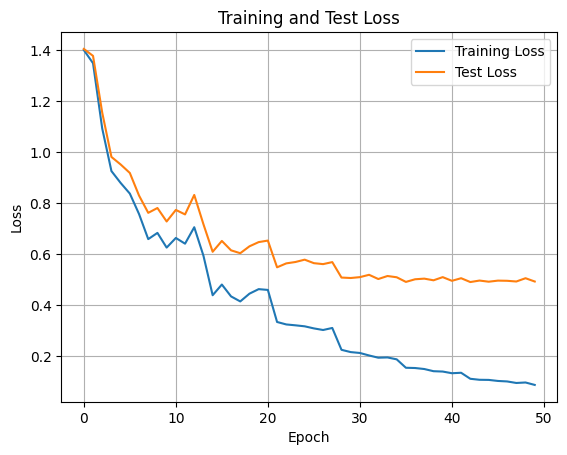

In [ ]:
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid()
plt.show()

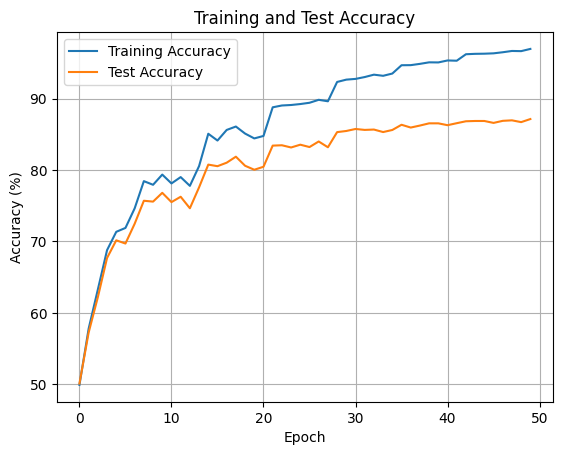

In [ ]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.legend()
plt.grid()
plt.show()

In [ ]:
torch.save(student.state_dict(), "/content/drive/MyDrive/Colab Notebooks/resnet18_student_learning.pth")

In [ ]:
# archive - previous run with T=2 and soft target loss weight = 0.3
num_epochs = 50
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

teacher.eval()

for epoch in range(num_epochs):
    student.train()

    for i, data in enumerate(train_loader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)

      optimizer.zero_grad()

      with torch.no_grad():
        teacher_inputs = transform_teacher(inputs)
        teacher_inputs = teacher_inputs.to(device)
        teacher_logits = teacher(teacher_inputs)

      student_logits = student(inputs)

      # soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
      # soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

      # soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)
      soft_targets_loss = criterion_kd(torch.log_softmax(student_logits / T, dim=1),
                               torch.softmax(teacher_logits / T, dim=1))
      label_loss = criterion(student_logits, labels)

      loss = soft_target_loss_weight * soft_targets_loss + (1 - soft_target_loss_weight) * label_loss
      loss.backward()
      optimizer.step()

    # Evaluate
    # on training data without augment
    student.eval()
    current_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for data in train_loader_val:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(current_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)
    print('[%d] train_loss: %.3f, train_accuracy: %.2f %%' %
     (epoch + 1, current_loss / len(train_loader), 100 * correct / total))

    # on testing data
    correct_test = 0
    total_test = 0
    test_current_loss = 0.0
    with torch.no_grad():
      for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        test_current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_loss.append(test_current_loss / len(test_loader))
    test_accuracy.append(100 * correct_test / total_test)
    print('[%d] test_loss: %.3f, test_accuracy: %.2f %%' %
     (epoch + 1, test_current_loss / len(test_loader), 100 * correct_test / total_test))

    scheduler.step()

[1] train_loss: 1.521, train_accuracy: 44.20 %
[1] test_loss: 1.514, test_accuracy: 44.40 %
[2] train_loss: 1.250, train_accuracy: 54.94 %
[2] test_loss: 1.260, test_accuracy: 53.94 %
[3] train_loss: 1.093, train_accuracy: 60.85 %
[3] test_loss: 1.124, test_accuracy: 60.00 %
[4] train_loss: 1.020, train_accuracy: 64.03 %
[4] test_loss: 1.042, test_accuracy: 63.59 %
[5] train_loss: 0.917, train_accuracy: 67.77 %
[5] test_loss: 0.959, test_accuracy: 66.20 %
[6] train_loss: 1.038, train_accuracy: 65.15 %
[6] test_loss: 1.089, test_accuracy: 64.84 %
[7] train_loss: 0.856, train_accuracy: 70.62 %
[7] test_loss: 0.905, test_accuracy: 69.52 %
[8] train_loss: 0.661, train_accuracy: 77.25 %
[8] test_loss: 0.740, test_accuracy: 74.60 %
[9] train_loss: 0.667, train_accuracy: 77.36 %
[9] test_loss: 0.761, test_accuracy: 75.03 %
[10] train_loss: 0.643, train_accuracy: 77.77 %
[10] test_loss: 0.729, test_accuracy: 75.09 %
[11] train_loss: 0.687, train_accuracy: 76.63 %
[11] test_loss: 0.780, test_ac

## Intermediate layer transfer

In [95]:
class Hook():
    def __init__(self, layer):
        self.hook = layer.register_forward_hook(self.hook_fn)
        print(f"Hook Set: {layer}")
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

In [96]:
class ConvolutionalRegressor2(nn.Module):
    def __init__(self, in_channels=1024, out_channels=128, kernel_size=4, stride=2, padding=1):
        super(ConvolutionalRegressor2, self).__init__()
        self.regressor = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.init_weights()

    def init_weights(self):
        init.kaiming_uniform_(self.regressor[0].weight, mode='fan_in', nonlinearity='relu')
        if self.regressor[0].bias is not None:
            init.constant_(self.regressor[0].bias, 0)

    def forward(self, x):
        return self.regressor(x)

In [97]:
# Hyperparameters
learning_rate = 0.1
batch_size = 128
T = 3
soft_target_loss_weight = 0.3
intermediate_loss_weight = 0.6
ce_loss_weight = 1 - soft_target_loss_weight - intermediate_loss_weight

In [98]:
transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

transform_teacher = transforms.Compose([
        transforms.Resize(224),
    ])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [99]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_dataset_val = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [100]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_val = DataLoader(train_dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [101]:
teacher = models.resnet50()
teacher.fc = nn.Linear(teacher.fc.in_features, 10)
teacher.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/teacher_finetuned_cifar10_v2.pth'))
teacher = teacher.to(device)

In [102]:
student = models.resnet18()
student.fc = nn.Linear(student.fc.in_features, 10)
student = student.to(device)
for param in student.parameters():
    param.requires_grad = True

In [103]:
criterion = nn.CrossEntropyLoss()
criterion_kd = nn.KLDivLoss(reduction='batchmean')
criterion_mse = nn.MSELoss()
regressor1 = ConvolutionalRegressor2(64, 64, 4, 7).to(device)
regressor2 = ConvolutionalRegressor2(128, 128, 7, 7).to(device)
regressor3 = ConvolutionalRegressor2(256, 256, 7, 7).to(device)
regressor4 = ConvolutionalRegressor2(512, 512, 7, 7).to(device)
optimizer = optim.SGD(list(filter(lambda p: p.requires_grad, student.parameters())) + \
                      list(regressor1.parameters()) + list(regressor2.parameters()) + list(regressor3.parameters()) + list(regressor4.parameters()),
                      lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)

In [104]:
teacher_layer1 = teacher.layer1[-1].conv1
teacher_layer1_hook = Hook(teacher_layer1)
student_layer1 = student.layer1[-1].conv1
student_layer1_hook = Hook(student_layer1)

teacher_layer2 = teacher.layer2[-1].conv1
teacher_layer2_hook = Hook(teacher_layer2)
student_layer2 = student.layer2[-1].conv1
student_layer2_hook = Hook(student_layer2)

teacher_layer3 = teacher.layer3[-1].conv1
teacher_layer3_hook = Hook(teacher_layer3)
student_layer3 = student.layer3[-1].conv1
student_layer3_hook = Hook(student_layer3)

teacher_layer4 = teacher.layer4[-1].conv1
teacher_layer4_hook = Hook(teacher_layer4)
student_layer4 = student.layer4[-1].conv1
student_layer4_hook = Hook(student_layer4)

Hook Set: Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
Hook Set: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Hook Set: Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Hook Set: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Hook Set: Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Hook Set: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Hook Set: Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
Hook Set: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [105]:
num_epochs = 50
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

teacher.eval()

for epoch in range(num_epochs):
    student.train()
    regressor1.train()
    regressor2.train()

    for i, data in enumerate(train_loader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)

      optimizer.zero_grad()

      with torch.no_grad():
        teacher_inputs = transform_teacher(inputs)
        teacher_inputs = teacher_inputs.to(device)
        teacher_logits = teacher(teacher_inputs)

      student_logits = student(inputs)

      soft_targets_loss = criterion_kd(torch.log_softmax(student_logits / T, dim=1),
                               torch.softmax(teacher_logits / T, dim=1))
      label_loss = criterion(student_logits, labels)

      teacher_activations1 = teacher_layer1_hook.output
      student_activations1 = student_layer1_hook.output
      teacher_activations1_trans = regressor1.forward(teacher_activations1)
      mse_loss1 = criterion_mse(student_activations1, teacher_activations1_trans)

      teacher_activations2 = teacher_layer2_hook.output
      student_activations2 = student_layer2_hook.output
      teacher_activations2_trans = regressor2.forward(teacher_activations2)
      mse_loss2 = criterion_mse(student_activations2, teacher_activations2_trans)

      teacher_activations3 = teacher_layer3_hook.output
      student_activations3 = student_layer3_hook.output
      teacher_activations3_trans = regressor3.forward(teacher_activations3)
      mse_loss3 = criterion_mse(student_activations3, teacher_activations3_trans)

      teacher_activations4 = teacher_layer4_hook.output
      student_activations4 = student_layer4_hook.output
      teacher_activations4_trans = regressor4.forward(teacher_activations4)
      mse_loss4 = criterion_mse(student_activations4, teacher_activations4_trans)

      loss = soft_target_loss_weight * soft_targets_loss + \
      ce_loss_weight * label_loss + \
      intermediate_loss_weight * (mse_loss1 + mse_loss2 + mse_loss3 + mse_loss4)/4

      loss.backward()
      optimizer.step()

    # Evaluate
    # on training data without augment
    student.eval()
    regressor1.eval()
    regressor2.eval()
    current_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for data in train_loader_val:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(current_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)
    print('[%d] train_loss: %.3f, train_accuracy: %.2f %%' %
     (epoch + 1, current_loss / len(train_loader), 100 * correct / total))

    # on testing data
    correct_test = 0
    total_test = 0
    test_current_loss = 0.0
    with torch.no_grad():
      for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        test_current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_loss.append(test_current_loss / len(test_loader))
    test_accuracy.append(100 * correct_test / total_test)
    print('[%d] test_loss: %.3f, test_accuracy: %.2f %%' %
     (epoch + 1, test_current_loss / len(test_loader), 100 * correct_test / total_test))

    scheduler.step()

student_layer1_hook.close()
teacher_layer1_hook.close()
student_layer2_hook.close()
teacher_layer2_hook.close()

[1] train_loss: 1.615, train_accuracy: 45.85 %
[1] test_loss: 1.626, test_accuracy: 45.50 %
[2] train_loss: 1.302, train_accuracy: 56.89 %
[2] test_loss: 1.305, test_accuracy: 56.87 %
[3] train_loss: 1.116, train_accuracy: 62.62 %
[3] test_loss: 1.163, test_accuracy: 61.94 %
[4] train_loss: 1.163, train_accuracy: 63.55 %
[4] test_loss: 1.241, test_accuracy: 62.12 %
[5] train_loss: 1.143, train_accuracy: 65.39 %
[5] test_loss: 1.206, test_accuracy: 64.39 %
[6] train_loss: 1.122, train_accuracy: 67.16 %
[6] test_loss: 1.173, test_accuracy: 66.21 %
[7] train_loss: 0.923, train_accuracy: 70.85 %
[7] test_loss: 0.986, test_accuracy: 69.88 %
[8] train_loss: 1.026, train_accuracy: 70.16 %
[8] test_loss: 1.100, test_accuracy: 68.81 %
[9] train_loss: 0.715, train_accuracy: 77.81 %
[9] test_loss: 0.813, test_accuracy: 76.03 %
[10] train_loss: 0.831, train_accuracy: 75.20 %
[10] test_loss: 0.935, test_accuracy: 72.72 %
[11] train_loss: 0.763, train_accuracy: 77.32 %
[11] test_loss: 0.889, test_ac

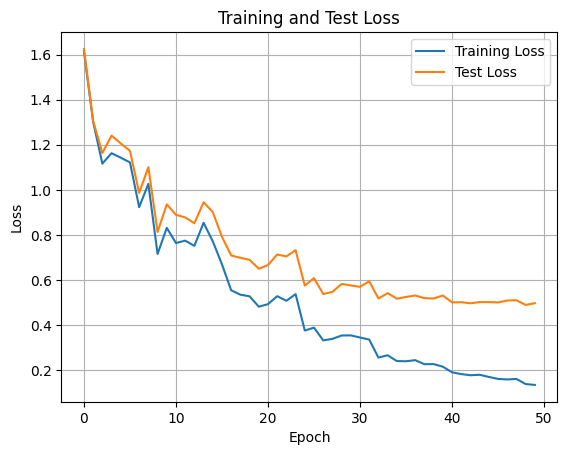

In [106]:
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid()
plt.show()

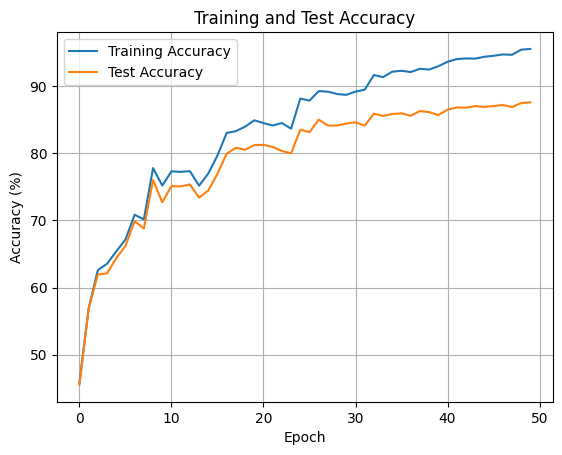

In [107]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.legend()
plt.grid()
plt.show()

In [109]:
torch.save(student.state_dict(), "/content/drive/MyDrive/Colab Notebooks/resnet18_student_learning_intermediate.pth")

In [63]:
# archive - match 4 layers but intermediate loss weight = 0.3
num_epochs = 50
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

teacher.eval()

for epoch in range(num_epochs):
    student.train()
    regressor1.train()
    regressor2.train()

    for i, data in enumerate(train_loader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)

      optimizer.zero_grad()

      with torch.no_grad():
        teacher_inputs = transform_teacher(inputs)
        teacher_inputs = teacher_inputs.to(device)
        teacher_logits = teacher(teacher_inputs)

      student_logits = student(inputs)

      soft_targets_loss = criterion_kd(torch.log_softmax(student_logits / T, dim=1),
                               torch.softmax(teacher_logits / T, dim=1))
      label_loss = criterion(student_logits, labels)

      teacher_activations1 = teacher_layer1_hook.output
      student_activations1 = student_layer1_hook.output
      teacher_activations1_trans = regressor1.forward(teacher_activations1)
      mse_loss1 = criterion_mse(student_activations1, teacher_activations1_trans)

      teacher_activations2 = teacher_layer2_hook.output
      student_activations2 = student_layer2_hook.output
      teacher_activations2_trans = regressor2.forward(teacher_activations2)
      mse_loss2 = criterion_mse(student_activations2, teacher_activations2_trans)

      teacher_activations3 = teacher_layer3_hook.output
      student_activations3 = student_layer3_hook.output
      teacher_activations3_trans = regressor3.forward(teacher_activations3)
      mse_loss3 = criterion_mse(student_activations3, teacher_activations3_trans)

      teacher_activations4 = teacher_layer4_hook.output
      student_activations4 = student_layer4_hook.output
      teacher_activations4_trans = regressor4.forward(teacher_activations4)
      mse_loss4 = criterion_mse(student_activations4, teacher_activations4_trans)

      loss = soft_target_loss_weight * soft_targets_loss + \
      ce_loss_weight * label_loss + \
      intermediate_loss_weight * (mse_loss1 + mse_loss2 + mse_loss3 + mse_loss4)/4

      loss.backward()
      optimizer.step()

    # Evaluate
    # on training data without augment
    student.eval()
    regressor1.eval()
    regressor2.eval()
    current_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for data in train_loader_val:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(current_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)
    print('[%d] train_loss: %.3f, train_accuracy: %.2f %%' %
     (epoch + 1, current_loss / len(train_loader), 100 * correct / total))

    # on testing data
    correct_test = 0
    total_test = 0
    test_current_loss = 0.0
    with torch.no_grad():
      for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        test_current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_loss.append(test_current_loss / len(test_loader))
    test_accuracy.append(100 * correct_test / total_test)
    print('[%d] test_loss: %.3f, test_accuracy: %.2f %%' %
     (epoch + 1, test_current_loss / len(test_loader), 100 * correct_test / total_test))

    scheduler.step()

student_layer1_hook.close()
teacher_layer1_hook.close()
student_layer2_hook.close()
teacher_layer2_hook.close()

[1] train_loss: 1.564, train_accuracy: 49.31 %
[1] test_loss: 1.574, test_accuracy: 49.57 %
[2] train_loss: 1.389, train_accuracy: 57.96 %
[2] test_loss: 1.444, test_accuracy: 57.51 %
[3] train_loss: 1.141, train_accuracy: 64.82 %
[3] test_loss: 1.166, test_accuracy: 64.93 %
[4] train_loss: 1.162, train_accuracy: 65.90 %
[4] test_loss: 1.227, test_accuracy: 64.53 %
[5] train_loss: 0.975, train_accuracy: 69.46 %
[5] test_loss: 1.055, test_accuracy: 68.33 %
[6] train_loss: 0.957, train_accuracy: 70.30 %
[6] test_loss: 1.018, test_accuracy: 69.53 %
[7] train_loss: 0.987, train_accuracy: 70.43 %
[7] test_loss: 1.042, test_accuracy: 69.33 %
[8] train_loss: 0.781, train_accuracy: 76.30 %
[8] test_loss: 0.867, test_accuracy: 74.70 %
[9] train_loss: 0.700, train_accuracy: 78.42 %
[9] test_loss: 0.813, test_accuracy: 76.56 %
[10] train_loss: 0.832, train_accuracy: 75.61 %
[10] test_loss: 0.948, test_accuracy: 73.30 %
[11] train_loss: 0.777, train_accuracy: 76.74 %
[11] test_loss: 0.893, test_ac

In [33]:
# archive - matching 2 layers only
num_epochs = 50
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

teacher.eval()

for epoch in range(num_epochs):
    student.train()
    regressor1.train()
    regressor2.train()

    for i, data in enumerate(train_loader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)

      optimizer.zero_grad()

      with torch.no_grad():
        teacher_inputs = transform_teacher(inputs)
        teacher_inputs = teacher_inputs.to(device)
        teacher_logits = teacher(teacher_inputs)

      student_logits = student(inputs)

      soft_targets_loss = criterion_kd(torch.log_softmax(student_logits / T, dim=1),
                               torch.softmax(teacher_logits / T, dim=1))
      label_loss = criterion(student_logits, labels)

      teacher_activations1 = teacher_layer1_hook.output
      student_activations1 = student_layer1_hook.output
      teacher_activations1_trans = regressor1.forward(teacher_activations1)
      mse_loss1 = criterion_mse(student_activations1, teacher_activations1_trans)
      teacher_activations2 = teacher_layer2_hook.output
      student_activations2 = student_layer2_hook.output
      teacher_activations2_trans = regressor2.forward(teacher_activations2)
      mse_loss2 = criterion_mse(student_activations2, teacher_activations2_trans)

      loss = soft_target_loss_weight * soft_targets_loss + \
      ce_loss_weight * label_loss + \
      intermediate_loss_weight * (mse_loss1 + mse_loss2)/2

      loss.backward()
      optimizer.step()

    # Evaluate
    # on training data without augment
    student.eval()
    regressor1.eval()
    regressor2.eval()
    current_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for data in train_loader_val:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(current_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)
    print('[%d] train_loss: %.3f, train_accuracy: %.2f %%' %
     (epoch + 1, current_loss / len(train_loader), 100 * correct / total))

    # on testing data
    correct_test = 0
    total_test = 0
    test_current_loss = 0.0
    with torch.no_grad():
      for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        test_current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_loss.append(test_current_loss / len(test_loader))
    test_accuracy.append(100 * correct_test / total_test)
    print('[%d] test_loss: %.3f, test_accuracy: %.2f %%' %
     (epoch + 1, test_current_loss / len(test_loader), 100 * correct_test / total_test))

    scheduler.step()

student_layer1_hook.close()
teacher_layer1_hook.close()
student_layer2_hook.close()
teacher_layer2_hook.close()

[1] train_loss: 1.605, train_accuracy: 46.88 %
[1] test_loss: 1.625, test_accuracy: 46.35 %
[2] train_loss: 1.334, train_accuracy: 58.42 %
[2] test_loss: 1.370, test_accuracy: 58.09 %
[3] train_loss: 1.093, train_accuracy: 64.42 %
[3] test_loss: 1.135, test_accuracy: 63.93 %
[4] train_loss: 1.118, train_accuracy: 64.73 %
[4] test_loss: 1.179, test_accuracy: 64.22 %
[5] train_loss: 0.926, train_accuracy: 69.29 %
[5] test_loss: 1.012, test_accuracy: 68.18 %
[6] train_loss: 0.994, train_accuracy: 69.09 %
[6] test_loss: 1.087, test_accuracy: 67.66 %
[7] train_loss: 1.062, train_accuracy: 68.19 %
[7] test_loss: 1.150, test_accuracy: 66.13 %
[8] train_loss: 0.676, train_accuracy: 78.32 %
[8] test_loss: 0.770, test_accuracy: 76.18 %
[9] train_loss: 0.660, train_accuracy: 79.15 %
[9] test_loss: 0.763, test_accuracy: 76.08 %
[10] train_loss: 0.721, train_accuracy: 77.94 %
[10] test_loss: 0.837, test_accuracy: 75.45 %
[11] train_loss: 0.626, train_accuracy: 80.00 %
[11] test_loss: 0.735, test_ac

## Plot normalized loss

In [6]:
non_learning_student = [
    1.621,
    1.338,
    1.336,
    1.056,
    0.973,
    1.062,
    0.982,
    0.797,
    0.772,
    0.790,
    0.728,
    0.793,
    0.727,
    0.745,
    0.617,
    0.602,
    0.611,
    0.587,
    0.592,
    0.591,
    0.658,
    0.504,
    0.515,
    0.548,
    0.533,
    0.547,
    0.558,
    0.524,
    0.483,
    0.498,
    0.490,
    0.499,
    0.498,
    0.510,
    0.509,
    0.476,
    0.504,
    0.485,
    0.493,
    0.479,
    0.495,
    0.505,
    0.492,
    0.491,
    0.497,
    0.505,
    0.503,
    0.508,
    0.508,
    0.504,
]
learning_student = [
    1.406,
    1.378,
    1.155,
    0.982,
    0.952,
    0.919,
    0.830,
    0.762,
    0.781,
    0.728,
    0.773,
    0.756,
    0.832,
    0.717,
    0.609,
    0.652,
    0.615,
    0.604,
    0.631,
    0.647,
    0.653,
    0.548,
    0.564,
    0.569,
    0.578,
    0.564,
    0.561,
    0.569,
    0.508,
    0.506,
    0.510,
    0.519,
    0.502,
    0.514,
    0.509,
    0.491,
    0.501,
    0.504,
    0.497,
    0.510,
    0.495,
    0.505,
    0.490,
    0.496,
    0.492,
    0.496,
    0.495,
    0.492,
    0.505,
    0.492,
]
intermediate_student = [
    1.626,
    1.305,
    1.163,
    1.241,
    1.206,
    1.173,
    0.986,
    1.100,
    0.813,
    0.935,
    0.889,
    0.877,
    0.851,
    0.945,
    0.901,
    0.791,
    0.708,
    0.698,
    0.689,
    0.649,
    0.666,
    0.712,
    0.704,
    0.732,
    0.574,
    0.608,
    0.537,
    0.547,
    0.582,
    0.575,
    0.569,
    0.594,
    0.517,
    0.541,
    0.516,
    0.524,
    0.530,
    0.519,
    0.517,
    0.530,
    0.500,
    0.500,
    0.496,
    0.501,
    0.501,
    0.499,
    0.508,
    0.509,
    0.488,
    0.496,
]

In [8]:
norm_non_learning_student = (non_learning_student-np.min(non_learning_student))/(np.max(non_learning_student)-np.min(non_learning_student)) 
norm_learning_student = (learning_student-np.min(learning_student))/(np.max(learning_student)-np.min(learning_student)) 
norm_intermediate_student = (intermediate_student-np.min(intermediate_student))/(np.max(intermediate_student)-np.min(intermediate_student)) 

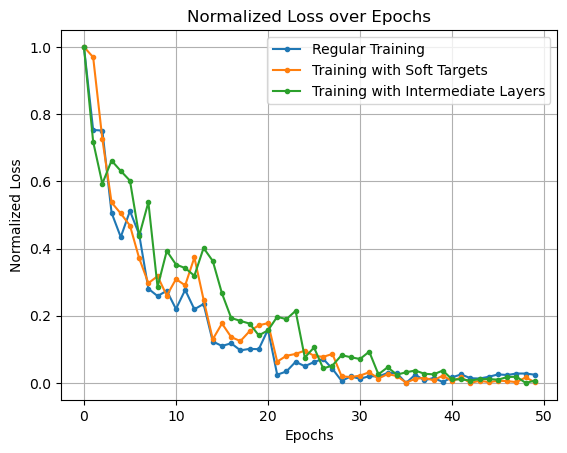

In [16]:
plt.plot(norm_non_learning_student, marker='o', markersize=3, label = 'Regular Training')
plt.plot(norm_learning_student, marker='o', markersize=3, label = 'Training with Soft Targets')
plt.plot(norm_intermediate_student, marker='o', markersize=3, label = 'Training with Intermediate Layers')
plt.title('Normalized Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Normalized Loss')
plt.legend()
plt.grid()